# Detection of Breast Cancer Cells

Breast cancer cells detection from microscopy images

Workflow stages:

    1. Question or problem definition.
    2. Import protocol, acquire training and testing data.
    3. Data preparations
    4. Model, predict and solve the problem.
    5. Visualize, report, and present the problem-solving steps and final solution.
    6. Supply or submit the results.

# Chapter 1: Question or problem definition

(1) "The BreaKHis database contains microscopic biopsy images of benign and malignant breast tumors. Images were collected through a clinical study from January 2014 to December 2014. All patients referred to the P&D Laboratory, Brazil, during this period of time, with a clinical indication of BC were invited to participate in the study. The institutional review board approved the study and all patients gave written informed consent. All the data were anonymized."

(2) "An Olympus BX-50 system microscope with a relay lens with magnification of 3.3× coupled to a Samsung digital color camera SCC-131AN is used to obtain digitized images from the breast tissue slides. This camera uses a 1/3” Sony Super-HAD (Hole-Accumulation Diode) interline transfer charge-coupled device with pixel size 6.5 μm × 6.25 μm and a total pixel number of 752 × 582. Images are acquired in three-channel red–green–blue (RGB) TrueColor (24-bit color depth, 8 bits per color channel) color space using magnifying factors of 40× , 100×, 200×, and 400×, corresponding to objective lens 4×, 10× , 20×, and 40×. The camera is set for automatic exposure and focusing is done manually on the microscope looking at the digital image on the computer screen."

Source:

FA Spanhol, LS Oliveira, C. Petitjean and L. Heutte, "A Dataset for Breast Cancer Histopathological Image Classification," in IEEE Transactions on Biomedical Engineering, vol. 63, no. 7, pp. 1455-1462, July 2016, doi: 10.1109/TBME.2015.2496264.

# Chapter 2: Import protocol, acquire training and testing data

In [20]:
# Pytorch tlements
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sn

# Post-deep learning analysis
from sklearn.metrics import confusion_matrix

# Support libraries
import numpy as np
import pandas as pd
import itertools
import os
import random

In [19]:
# Use GPU if available
gpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(gpu_device)

cuda


# Chapter 3: Data preparations

In [3]:
batch_size_train=16
batch_size_test=32

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((246,246)),
    ])

# Create datasets for training and validation
training_set = datasets.ImageFolder('./train', transform=transform)
test_set = datasets.ImageFolder('./test', transform=transform)

# Create data loaders for our datasets; shuffle for training and validation, not for Testing
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)
validation_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

# Class labels
classes = ('benign', 'malignant')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Test set has {} instances'.format(len(test_set)))

Training set has 1148 instances
Test set has 545 instances


## Display of the 1st train batch

benign  benign  malignant  benign  benign  malignant  malignant  benign  benign  benign  benign  malignant  benign  benign  benign  malignant


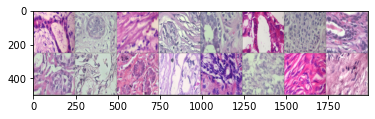

In [5]:
# Image display function
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
print('  '.join(classes[labels[j]] for j in range(batch_size_train)))

# Chapter 4: Model, predict and solve the problem

## Construction of a deep neural network built on pre-trained vgg16 model with CNN train locked and fully connected layers un-trained and open for changes.

In [6]:
class my_vgg16(nn.Module):
    def __init__(self, originalModel, num_of_channels=3, num_classes=2):
        super(my_vgg16, self).__init__()
        self.features = nn.Sequential(*list(originalModel.features)[:])  
           
        self.fully_connected_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
          
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fully_connected_layers(x)
        return x

In [7]:
# Build model and check its properties
model_vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
print(model_vgg16)
for i, param in enumerate(model_vgg16.parameters()):
    param.requires_grad = False
    print(i)
    print(param.requires_grad)
model = my_vgg16(model_vgg16)
print(model)
for i, param in enumerate(model.parameters()):
    print(i)
    print(param.requires_grad)

# If GPU is available
if gpu_device == 'cuda':
    model.to(gpu_device)           ### GPU

Using cache found in C:\Users\Welcome/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# Creating initial batch
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(batch_size_train, 2)
dummy_labels = torch.randint(low=0, high=2, size=(batch_size_train,))
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {:.4f}'.format(loss.item()))

tensor([[0.6089, 0.0787],
        [0.3590, 0.0934],
        [0.7058, 0.0569],
        [0.5975, 0.4972],
        [0.8660, 0.4274],
        [0.7929, 0.4487],
        [0.8493, 0.0115],
        [0.6921, 0.4298],
        [0.6413, 0.2368],
        [0.5261, 0.2840],
        [0.6138, 0.5573],
        [0.3520, 0.5680],
        [0.4230, 0.9259],
        [0.6150, 0.1864],
        [0.0884, 0.8235],
        [0.2230, 0.7884]])
tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0])
Total loss for this batch: 0.7045


In [9]:
# Optimizers initiation
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# One loop training function
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):

        # Every data instance is an input + label pair
        inputs, labels = data
        
        # If GPU is available
        if gpu_device == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()           ### GPU
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 12 == 1:
            last_loss = running_loss / batch_size_train
            print("\rbatch {}/{}, loss: {:.4f}".format(i+1, len(training_loader), last_loss, end='', flush=True))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
                   
    return last_loss

In [11]:
# Initializing TensorBoard data writer
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/Breast_cancer_trainer_{}'.format(timestamp))
epoch_number = 0

## Training and validation loops

In [12]:
total_epochs = 3

best_vloss = 1_000_000.

for epoch in range(total_epochs):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Turn gradient tracking on, and train
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)                           
    
    # Turn gradient tracking off
    model.train(False)
    
    # Run validation
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        # If GPU is available
        if gpu_device == 'cuda':
            vinputs, vlabels = vinputs.cuda(), vlabels.cuda()           ### GPU
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
                    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {:.4f} valid {:.4f}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch for training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
batch 0/72, loss: 0.0446
batch 12/72, loss: 0.4759
batch 24/72, loss: 0.4464
batch 36/72, loss: 0.4247
batch 48/72, loss: 0.4135
batch 60/72, loss: 0.4017
LOSS train 0.4017 valid 0.4367
EPOCH 2:
batch 0/72, loss: 0.0390
batch 12/72, loss: 0.3056
batch 24/72, loss: 0.3468
batch 36/72, loss: 0.2980
batch 48/72, loss: 0.2890
batch 60/72, loss: 0.2502
LOSS train 0.2502 valid 0.2838
EPOCH 3:
batch 0/72, loss: 0.0157
batch 12/72, loss: 0.2524
batch 24/72, loss: 0.1975
batch 36/72, loss: 0.2067
batch 48/72, loss: 0.2191
batch 60/72, loss: 0.1721
LOSS train 0.1721 valid 0.1858
EPOCH 4:
batch 0/72, loss: 0.0125
batch 12/72, loss: 0.1371
batch 24/72, loss: 0.1471
batch 36/72, loss: 0.1528
batch 48/72, loss: 0.1797
batch 60/72, loss: 0.1829
LOSS train 0.1829 valid 0.1198
EPOCH 5:
batch 0/72, loss: 0.0083
batch 12/72, loss: 0.1019
batch 24/72, loss: 0.0646
batch 36/72, loss: 0.0962
batch 48/72, loss: 0.1003
batch 60/72, loss: 0.1409
LOSS train 0.1409 valid 0.0582
EPOCH 6:
batch 0/72, loss

## TensorBoard output:

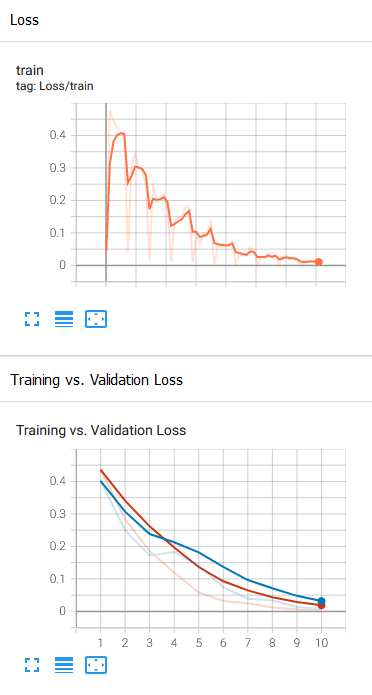

### Tensor board results shows good trainning and validation loss trends.

## Test

In [42]:
y_pred = []
y_true = []

for i, vdata in enumerate(test_loader):
    vinputs, vlabels = vdata
    # If GPU is available
    if gpu_device == 'cuda':
        vinputs, vlabels = vinputs.cuda(), vlabels.cuda()           ### GPU
    voutputs = model(vinputs)
    output = (torch.max(torch.exp(voutputs), 1)[1]).numpy()
    y_pred.extend(output)
    y_true.extend(vlabels.numpy())
    
    if i % 5 == 0:
        print("\rTest batch {}/{}".format(i, len(test_loader), end='', flush=True))

Test batch 0/18
Test batch 5/18
Test batch 10/18
Test batch 15/18


# Chapter 5: Visualize, report, and present the problem-solving steps and final solution

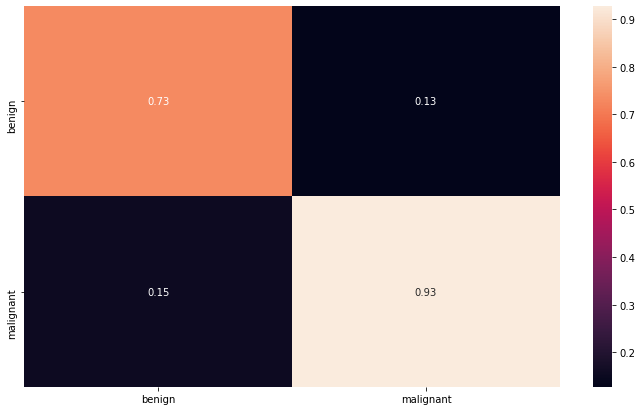

In [43]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

**Discussion:**
    
* While +90% is high for True positive cancer cells, in the case of cancer cell detection, it is most important to detect the True positive results even at a price of higher false positive. A possible solution is to define any borderline result as positive malignant.

**Summary**

* Data was imported, organized, and prepared for modeling.

* The pre-trained vgg16 model was imported with its CNN layers weights locked and fully connected layers open for changes.

* The final prediction had over 90% accuracy in predicting malignant cancer cells.

**Future Tasks:** 

* Improve True positive even at the price of higher false positive.
* Examine the opening of more layers for training.
* Explore shallower neural networks.


# Chapter 6: Supply or submit the results.

Test data confusion matrix image was creaded ('output.png')